In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import os
import copy

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.hyperparameter_tuning import *

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


# Model 1a Performance with Storage
Analyze Model 1a performance if storage is explicitly given.

## Data Processing

In [3]:
def data_processing(name, transform_type, train_frac=0.6, val_frac=0.2, test_frac=0.2, left='1944-01-01', right='2022-12-31', log_names=[], return_scaler=False, storage=True):
    """
    Run data processing pipeline.
    Params:
    name -- str, name of reservoir to read
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    log_names -- list of column names (str) to take log of before running rest of pipeline. E.g. ['inflow', 'outflow', 'storage']
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    storage -- bool, whether or not to include storage data in features
    """

    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Take log of df columns that are in log_names
    for column_name in df.columns:
        if column_name in log_names:
            df[column_name] = np.log(df[column_name])
        else:
            continue

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    # select inflow, STORAGE, and doy as input features
    if storage:
        X_train, X_val, X_test = ts_train[:, :, [0, 2, 3]], ts_val[:, :, [0, 2, 3]], ts_test[:, :, [0, 2, 3]]
    else:
        X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [4]:
class multi_reservoir_data:
    """Store data from multiple reservoirs"""
    def __init__(self, left_years_dict, storage=True):
        """ 
        Params:
        left_years_dict: dict, dictionary of year of first available data from each requested reservoir (name : year)
        storage: whether or not to include storage in features
        """
        self.left_years_dict = left_years_dict
        self.storage = storage

        # Collect train, val, test tensors from each reservoir and their respective src.data.data_processing.time_scaler() objects
        self.X_train_dict = {}
        self.y_train_dict = {}
        self.X_val_dict = {}
        self.y_val_dict = {}
        self.X_test_dict = {}
        self.y_test_dict = {}
        self.scaler_dict = {}
        return
    
    def fetch_data(self):
        """Fetch data for each reservoir and process them into train/val/test tesors"""
        # Run data processing for each reservoir
        for reservoir, left_year in self.left_years_dict.items():
            result = data_processing(name=reservoir, transform_type='standardize', train_frac=0.6, val_frac=0.2, test_frac=0.2,
                                    left=f'{left_year}-01-01', right='2022-12-31',
                                    return_scaler=True, storage=self.storage)
            # Save results
            self.X_train_dict[reservoir] = result[0][0] # (# chunks, chunk size, # features (e.g. inflow and doy))
            self.y_train_dict[reservoir] = result[0][1] # (# chunks, chunk size, 1 (outflow))
            self.X_val_dict[reservoir] = result[1][0]
            self.y_val_dict[reservoir] = result[1][1]
            self.X_test_dict[reservoir] = result[2][0]
            self.y_test_dict[reservoir] = result[2][1]
            self.scaler_dict[reservoir] = result[3]
        return
    
    def combine_reservoir_data(self):
        """ 
        Concatenate all fetched reservoir data into one train, val, test tensor
        """
        # Concat tensors along chunks dimension (dim = 0)
        X_train, y_train = torch.cat([self.X_train_dict[key] for key in self.left_years_dict], dim=0), torch.cat([self.y_train_dict[key] for key in self.left_years_dict], dim=0)
        X_val, y_val = torch.cat([self.X_val_dict[key] for key in self.left_years_dict], dim=0), torch.cat([self.y_val_dict[key] for key in self.left_years_dict], dim=0)
        X_test, y_test = torch.cat([self.X_test_dict[key] for key in self.left_years_dict], dim=0), torch.cat([self.y_test_dict[key] for key in self.left_years_dict], dim=0)

        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    
    def fetch_and_combine(self):
        """Run fetch_data and return combined tensors"""
        self.fetch_data()
        return self.combine_reservoir_data()

In [5]:
# Store first available years for each reservoir
left_years_dict = {'Shasta':1944, 'Folsom':1963, 'New_Melones':1980, 'Trinity':1963}
# Combine data from reservoirs (with storage)
data_collector_stg = multi_reservoir_data(left_years_dict=left_years_dict)
_ = data_collector_stg.fetch_and_combine()
# Combine data from reservoirs (no storage)
data_collector = multi_reservoir_data(left_years_dict=left_years_dict, storage=False)
_ = data_collector.fetch_and_combine()

## Fit models on Shasta, Folsom, Trinity, and New Melones
Use hyperparameters from Model 1a Shasta experiment.

In [6]:
# Model 1a archeticture
input_size = 3 # inflow, storage, doy
hidden_size1 = 30
hidden_size2 = 15
output_size = 1 # outflow
dropout_prob = 0.3
num_layers = 1

In [7]:
# Instantiate models
model_dict_stg = {}
for reservoir_key in left_years_dict:
    torch.manual_seed(0)
    model_dict_stg[reservoir_key] = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                                               hidden_size2=hidden_size2, output_size=output_size, 
                                               num_layers=num_layers, dropout_prob=dropout_prob)

# Save training/validation losses for each model
losses_dict_stg = {}

In [8]:
# Run training loop for each model
for reservoir_key in left_years_dict:
    # Create PyTorch Dataset and Dataloader for each reservoir
    dataset_train_res, dataset_val_res = (TensorDataset(data_collector_stg.X_train_dict[reservoir_key], 
                                                        data_collector_stg.y_train_dict[reservoir_key]), 
                                          TensorDataset(data_collector_stg.X_val_dict[reservoir_key], 
                                                        data_collector_stg.y_val_dict[reservoir_key]))
    dataloader_train_res, dataloader_val_res = (DataLoader(dataset_train_res, batch_size=1, shuffle=False), 
                                                DataLoader(dataset_val_res, batch_size=1, shuffle=False))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_dict_stg[reservoir_key].parameters(), lr=0.001)
    # Run training loop
    train_losses_res, val_losses_res = training_loop(model=model_dict_stg[reservoir_key], criterion=criterion, optimizer=optimizer, 
                                            patience=10, dataloader_train=dataloader_train_res, 
                                            dataloader_val=dataloader_val_res, epochs=1000)
    losses_dict_stg[reservoir_key] = (train_losses_res, val_losses_res)

Training epochs:   6%|▌         | 60/1000 [00:09<02:32,  6.15it/s]


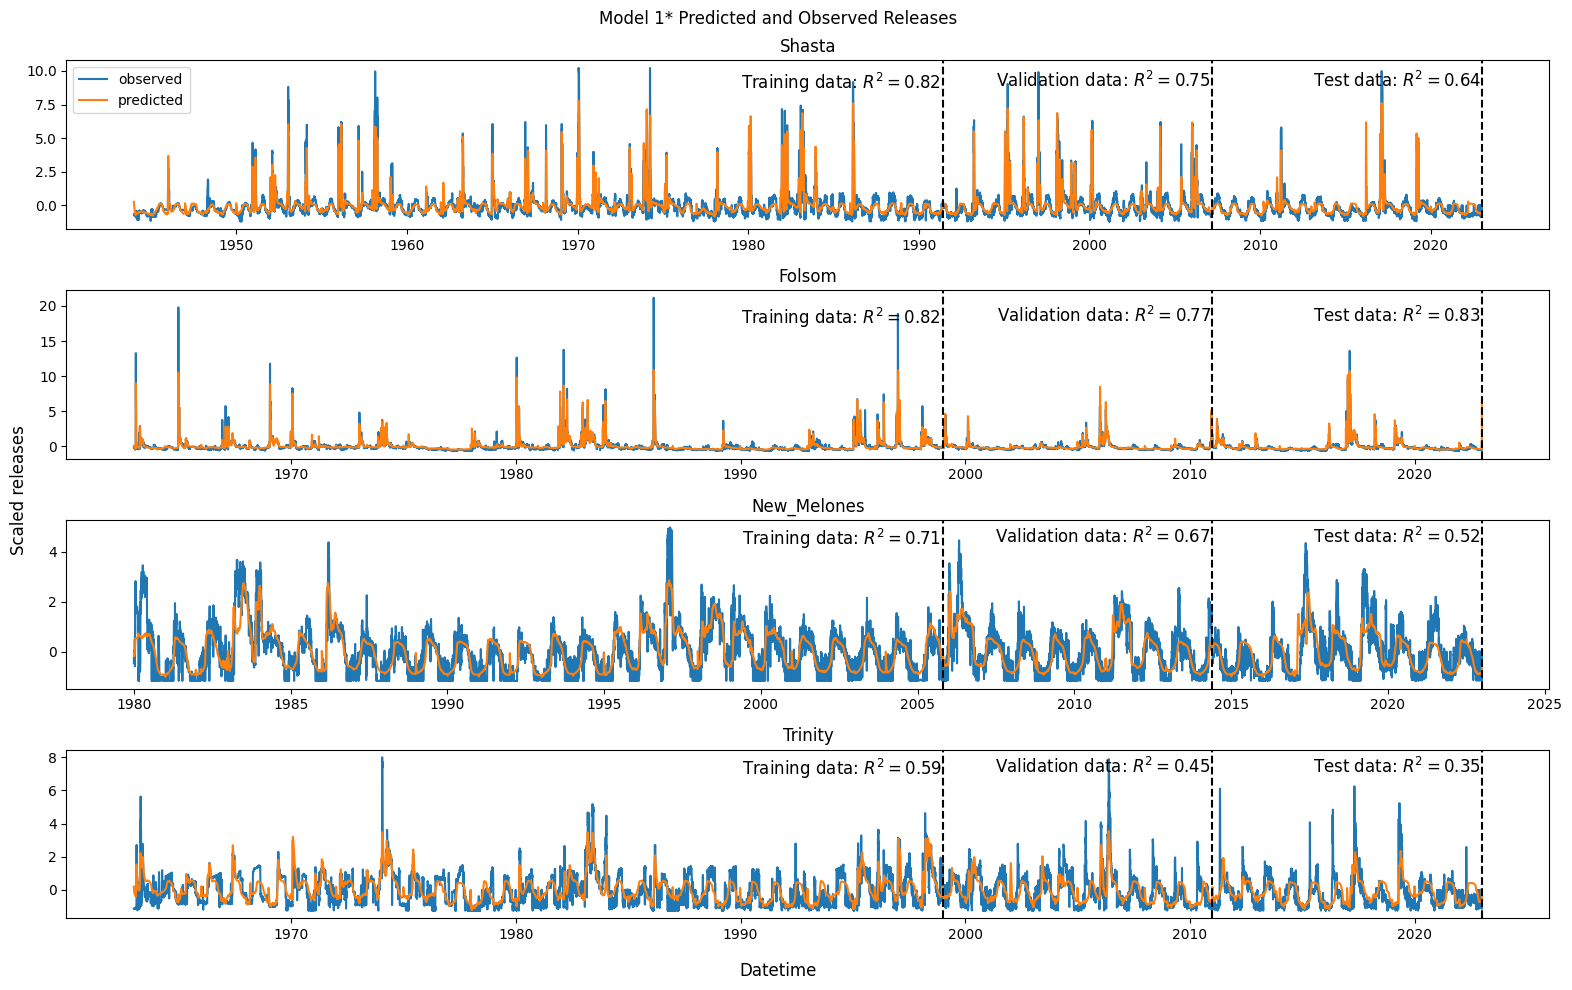

In [17]:
fig, ax = plt.subplots(figsize=(16, 10), nrows=len(left_years_dict))
text_ypos_dict = {'Shasta':10, 'Folsom':20, 'New_Melones':5, 'Trinity':8}
r2_dict_stg = {} # save r2 scores

for i, reservoir_key in enumerate(left_years_dict):
    reservoir_left_year = left_years_dict[reservoir_key] # left year window for each reservoir
    # evaluate metrics and plot
    r2_metrics = plot_and_eval(model=model_dict_stg[reservoir_key], 
                    X_train=data_collector_stg.X_train_dict[reservoir_key], X_val=data_collector_stg.X_val_dict[reservoir_key], X_test=data_collector_stg.X_test_dict[reservoir_key],
                    y_train=data_collector_stg.y_train_dict[reservoir_key], y_val=data_collector_stg.y_val_dict[reservoir_key], y_test=data_collector_stg.y_test_dict[reservoir_key],
                    datetime_index=pd.date_range(start=f'{reservoir_left_year}-01-01', end='2022-12-31', freq='D'),
                    ax=ax[i], text_ypos=text_ypos_dict[reservoir_key])
    # save metrics for reservoir
    r2_dict_stg[reservoir_key] = r2_metrics
    
    ax[i].set_title(reservoir_key)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    if i > 0:
        ax[i].get_legend().remove() # turn off legend for all except first axes

fig.supylabel('Scaled releases')
fig.supxlabel('Datetime')
fig.suptitle('Model 1* Predicted and Observed Releases')
plt.tight_layout()
plt.savefig('report/drafting/2_27_2024/figures/Model1_storage.png', dpi=300)
plt.show()

## Compare with models with no storage

In [12]:
# Model 1a archeticture
input_size = 2 # inflow, doy
hidden_size1 = 30
hidden_size2 = 15
output_size = 1 # outflow
dropout_prob = 0.3
num_layers = 1

In [13]:
# Instantiate models
model_dict = {}
for reservoir_key in left_years_dict:
    torch.manual_seed(0)
    model_dict[reservoir_key] = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                                               hidden_size2=hidden_size2, output_size=output_size, 
                                               num_layers=num_layers, dropout_prob=dropout_prob)

# Save training/validation losses for each model
losses_dict = {}

In [14]:
# Run training loop for each model
for reservoir_key in left_years_dict:
    # Create PyTorch Dataset and Dataloader for each reservoir
    dataset_train_res, dataset_val_res = (TensorDataset(data_collector.X_train_dict[reservoir_key], 
                                                        data_collector.y_train_dict[reservoir_key]), 
                                          TensorDataset(data_collector.X_val_dict[reservoir_key], 
                                                        data_collector.y_val_dict[reservoir_key]))
    dataloader_train_res, dataloader_val_res = (DataLoader(dataset_train_res, batch_size=1, shuffle=False), 
                                                DataLoader(dataset_val_res, batch_size=1, shuffle=False))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_dict[reservoir_key].parameters(), lr=0.001)
    # Run training loop 
    train_losses_res, val_losses_res = training_loop(model=model_dict[reservoir_key], criterion=criterion, optimizer=optimizer, 
                                            patience=10, dataloader_train=dataloader_train_res, 
                                            dataloader_val=dataloader_val_res, epochs=1000)
    losses_dict[reservoir_key] = (train_losses_res, val_losses_res)

Training epochs:   8%|▊         | 84/1000 [00:12<02:19,  6.58it/s]


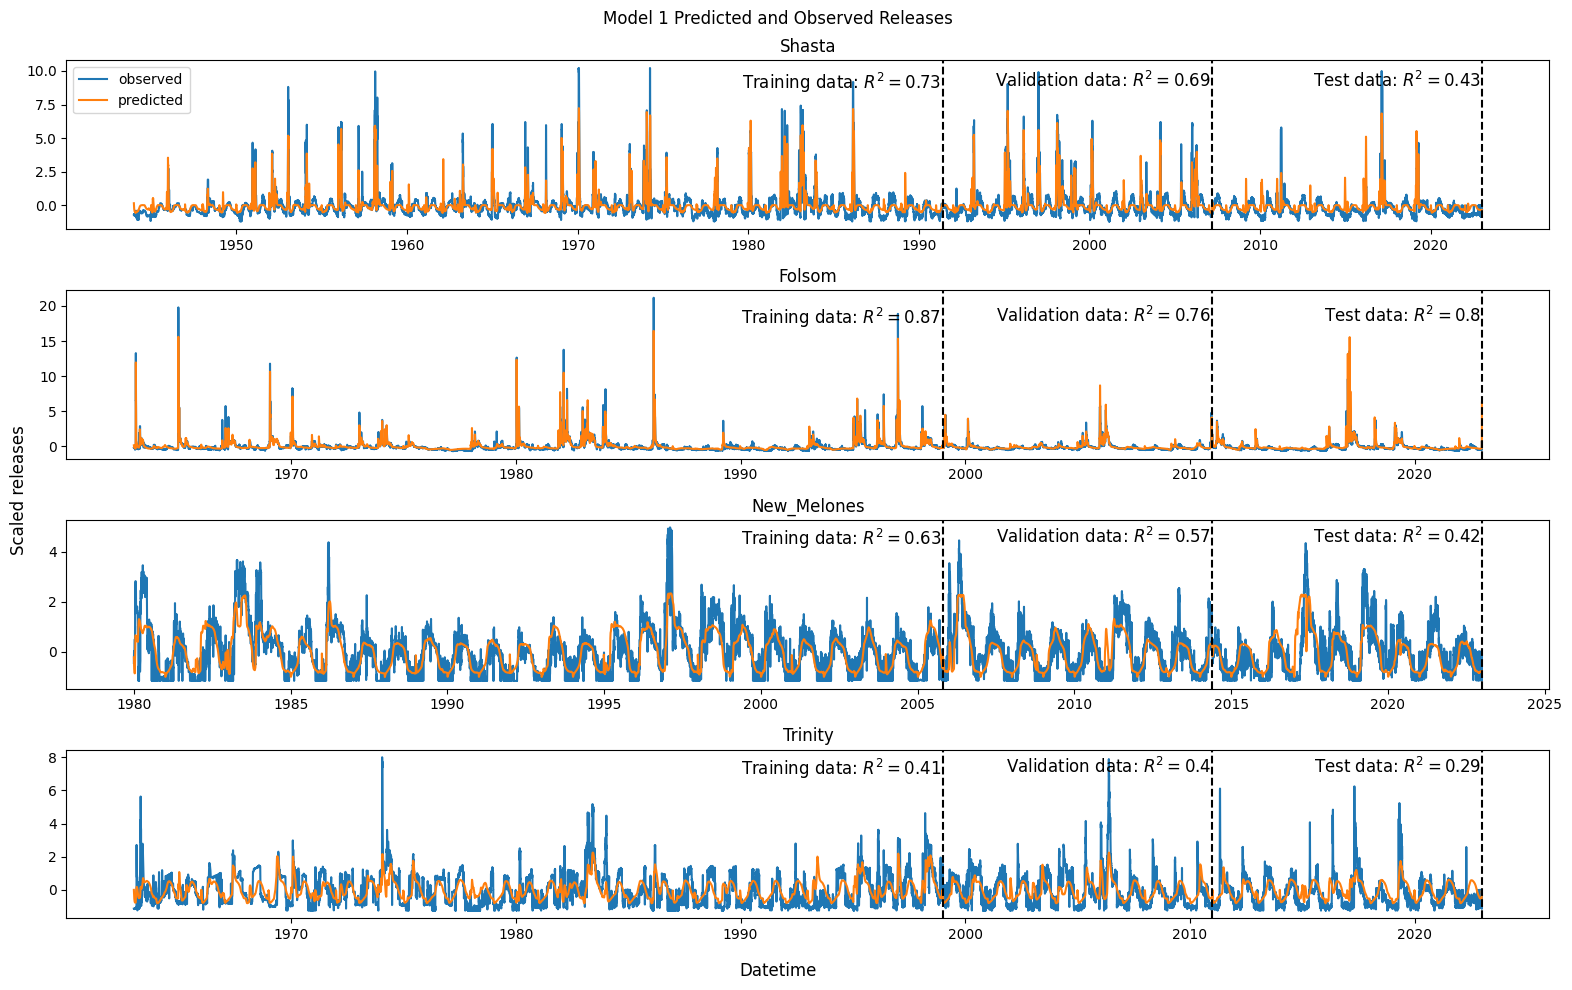

In [16]:
fig, ax = plt.subplots(figsize=(16, 10), nrows=len(left_years_dict))
text_ypos_dict = {'Shasta':10, 'Folsom':20, 'New_Melones':5, 'Trinity':8}
r2_dict = {} # save r2 metrics

for i, reservoir_key in enumerate(left_years_dict):
    reservoir_left_year = left_years_dict[reservoir_key] # left year window for each reservoir
    # evaluate and plot model for reservoir
    r2_metrics = plot_and_eval(model=model_dict[reservoir_key], 
                    X_train=data_collector.X_train_dict[reservoir_key], X_val=data_collector.X_val_dict[reservoir_key], X_test=data_collector.X_test_dict[reservoir_key],
                    y_train=data_collector.y_train_dict[reservoir_key], y_val=data_collector.y_val_dict[reservoir_key], y_test=data_collector.y_test_dict[reservoir_key],
                    datetime_index=pd.date_range(start=f'{reservoir_left_year}-01-01', end='2022-12-31', freq='D'),
                    ax=ax[i], text_ypos=text_ypos_dict[reservoir_key])
    # save r2 metrics for reservoir
    r2_dict[reservoir_key] = r2_metrics
    
    
    ax[i].set_title(reservoir_key)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    if i > 0:
        ax[i].get_legend().remove() # turn off legend for all except first axes

fig.supylabel('Scaled releases')
fig.supxlabel('Datetime')
fig.suptitle('Model 1 Predicted and Observed Releases')
plt.tight_layout()
plt.savefig('report/drafting/2_27_2024/figures/Model1_no_storage.png', dpi=300)
plt.show()

## Summarize performances

### No storage

In [35]:
df_r2_no_storage = pd.DataFrame(r2_dict, index=['train', 'validation', 'test'])
df_r2_no_storage

,Shasta,Folsom,New_Melones,Trinity
train,0.713796,0.861027,0.600432,0.365214
validation,0.634614,0.742718,0.555493,0.387631
test,0.340184,0.801888,0.409651,0.290762


### With storage

In [37]:
df_r2_storage = pd.DataFrame(r2_dict_stg, index=['train', 'validation', 'test'])
df_r2_storage

,Shasta,Folsom,New_Melones,Trinity
train,0.816416,0.820283,0.720535,0.610778
validation,0.753316,0.762361,0.674218,0.416939
test,0.650522,0.837938,0.556259,0.371798


Overall, the addition of storage benefits Shasta and New Melones significantly but not Folsom or Trinity.